In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size = 395
img_height = 224
img_width = 224

In [ ]:
data_dir = pathlib.Path("/content/drive/My Drive/main_data/train")

In [ ]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

1978


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1978 files belonging to 7 classes.
Using 1583 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1978 files belonging to 7 classes.
Using 395 files for validation.


In [ ]:
test_sample = 395

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Hand_Waving', 'Phoning', 'Running', 'Sitting', 'Standing', 'Walking', 'Yawning']


In [ ]:
val_class_names = val_ds.class_names
print(val_class_names)

['Hand_Waving', 'Phoning', 'Running', 'Sitting', 'Standing', 'Walking', 'Yawning']


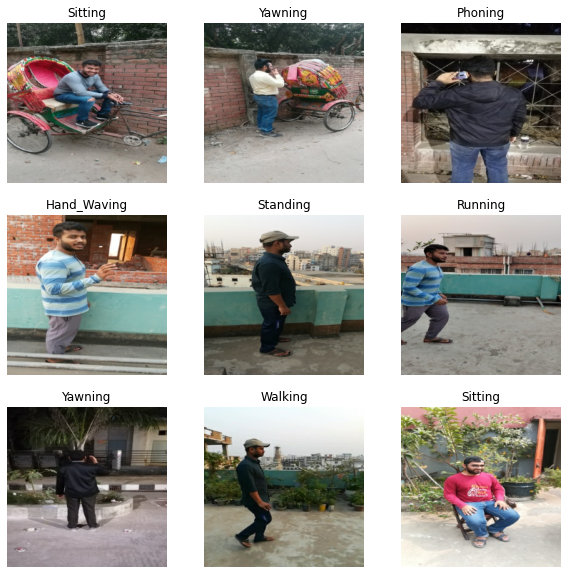

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(395, 224, 224, 3)
(395,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = 7

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


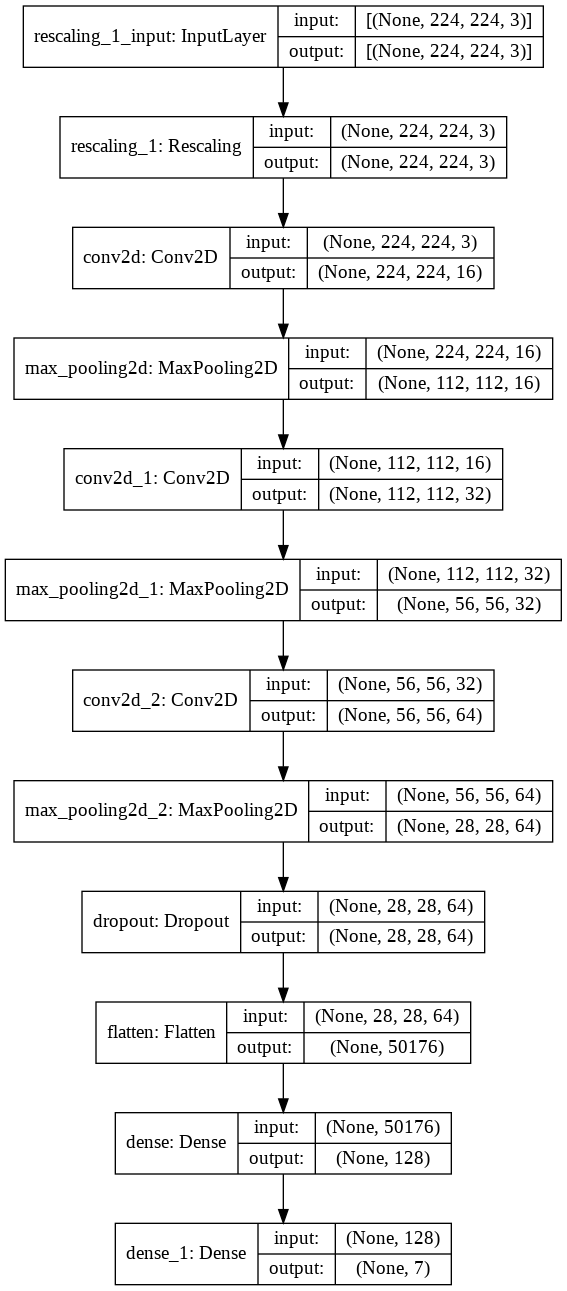

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

In [ ]:
earlyStopCb = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=10)
cnn_history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  callbacks=[earlyStopCb])

Epoch 1/100
5/5 [==============================] - 238s 51s/step - loss: 3.2007 - accuracy: 0.1312 - val_loss: 2.3057 - val_accuracy: 0.1291
Epoch 2/100
5/5 [==============================] - 77s 15s/step - loss: 2.1205 - accuracy: 0.1550 - val_loss: 1.9564 - val_accuracy: 0.2177
Epoch 3/100
5/5 [==============================] - 77s 15s/step - loss: 1.9346 - accuracy: 0.2231 - val_loss: 1.9277 - val_accuracy: 0.1873
Epoch 4/100
5/5 [==============================] - 76s 15s/step - loss: 1.9389 - accuracy: 0.1807 - val_loss: 1.9051 - val_accuracy: 0.1595
Epoch 5/100
5/5 [==============================] - 76s 15s/step - loss: 1.9046 - accuracy: 0.1757 - val_loss: 1.8749 - val_accuracy: 0.2051
Epoch 6/100
5/5 [==============================] - 76s 15s/step - loss: 1.8845 - accuracy: 0.1735 - val_loss: 1.8574 - val_accuracy: 0.2532
Epoch 7/100
5/5 [==============================] - 77s 15s/step - loss: 1.8170 - accuracy: 0.2403 - val_loss: 1.7900 - val_accuracy: 0.2582
Epoch 8/100
5/5 [==

In [ ]:
print(model.evaluate(val_ds))

1/1 [==============================] - 5s 5s/step - loss: 1.5737 - accuracy: 0.4506
[1.5736610889434814, 0.45063289999961853]


In [ ]:
!pip install keract

rescaling_1_input (1, 224, 224, 3) 


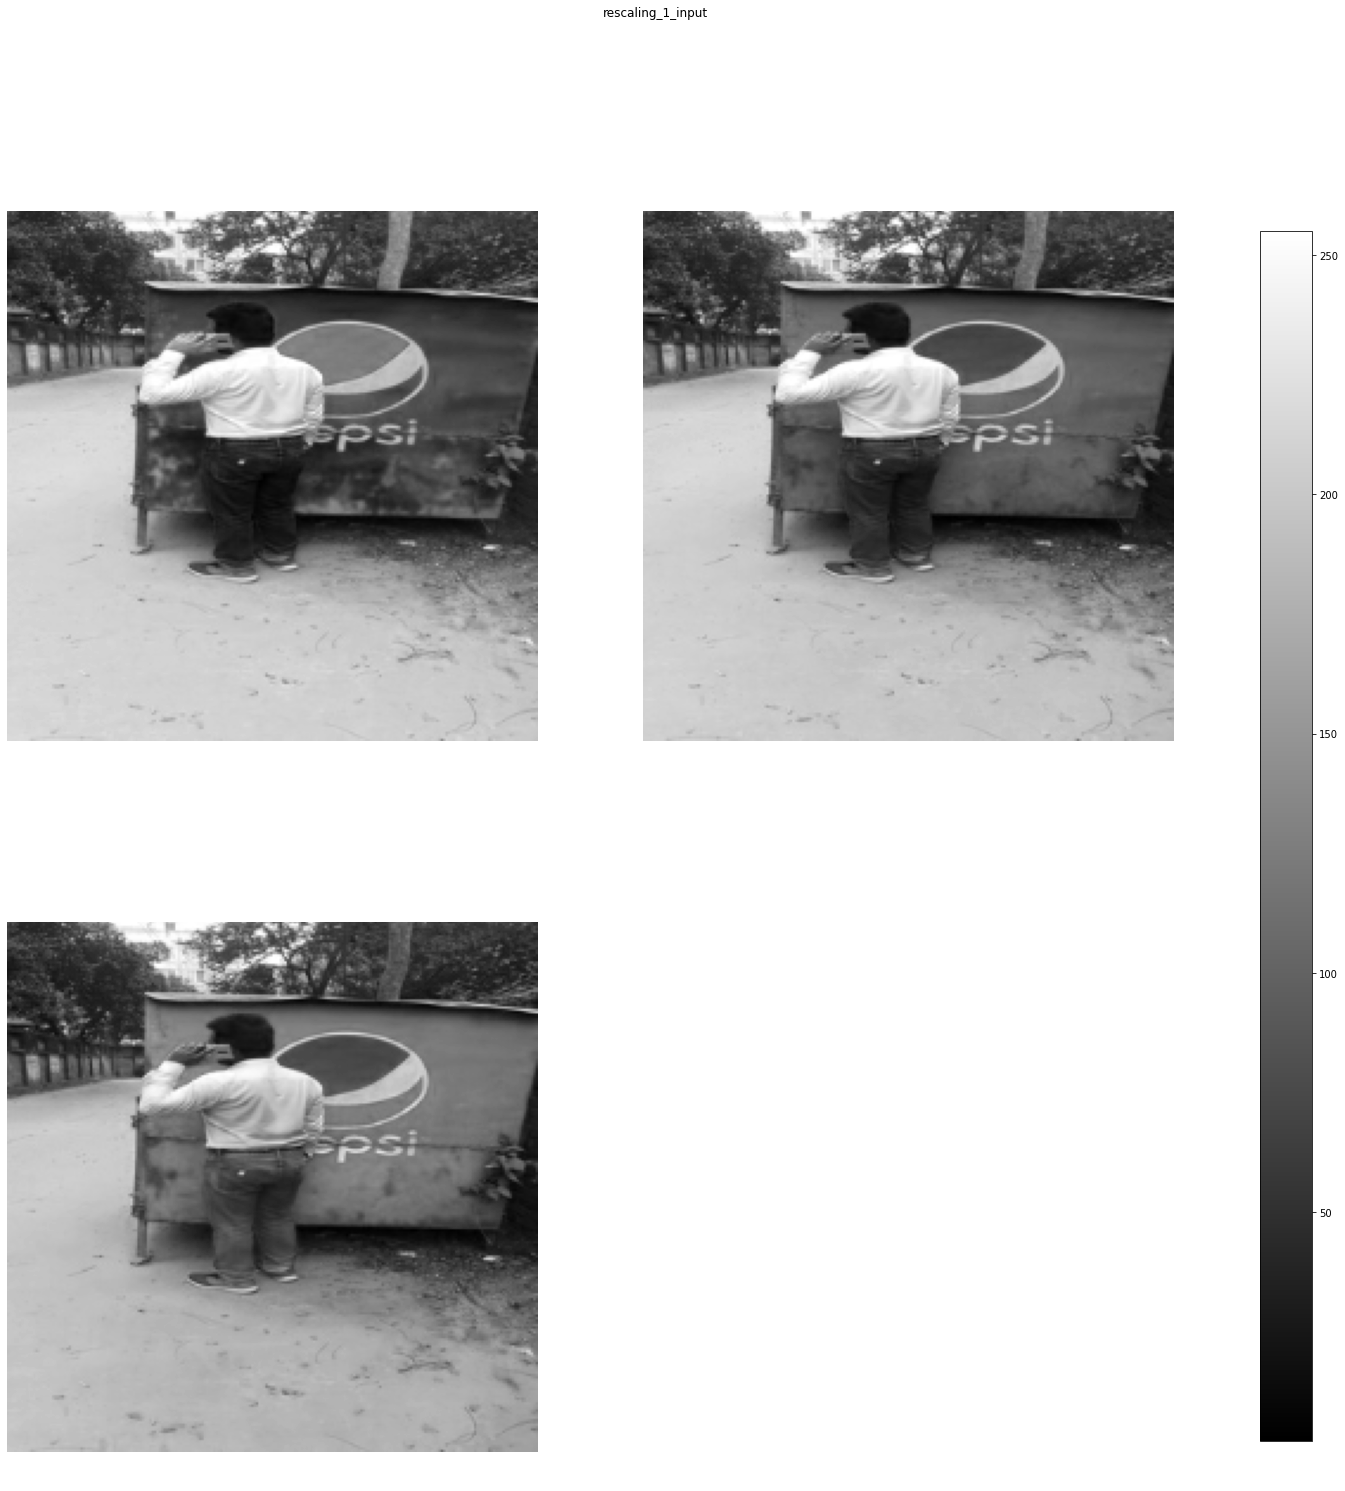

rescaling_1 (1, 224, 224, 3) 


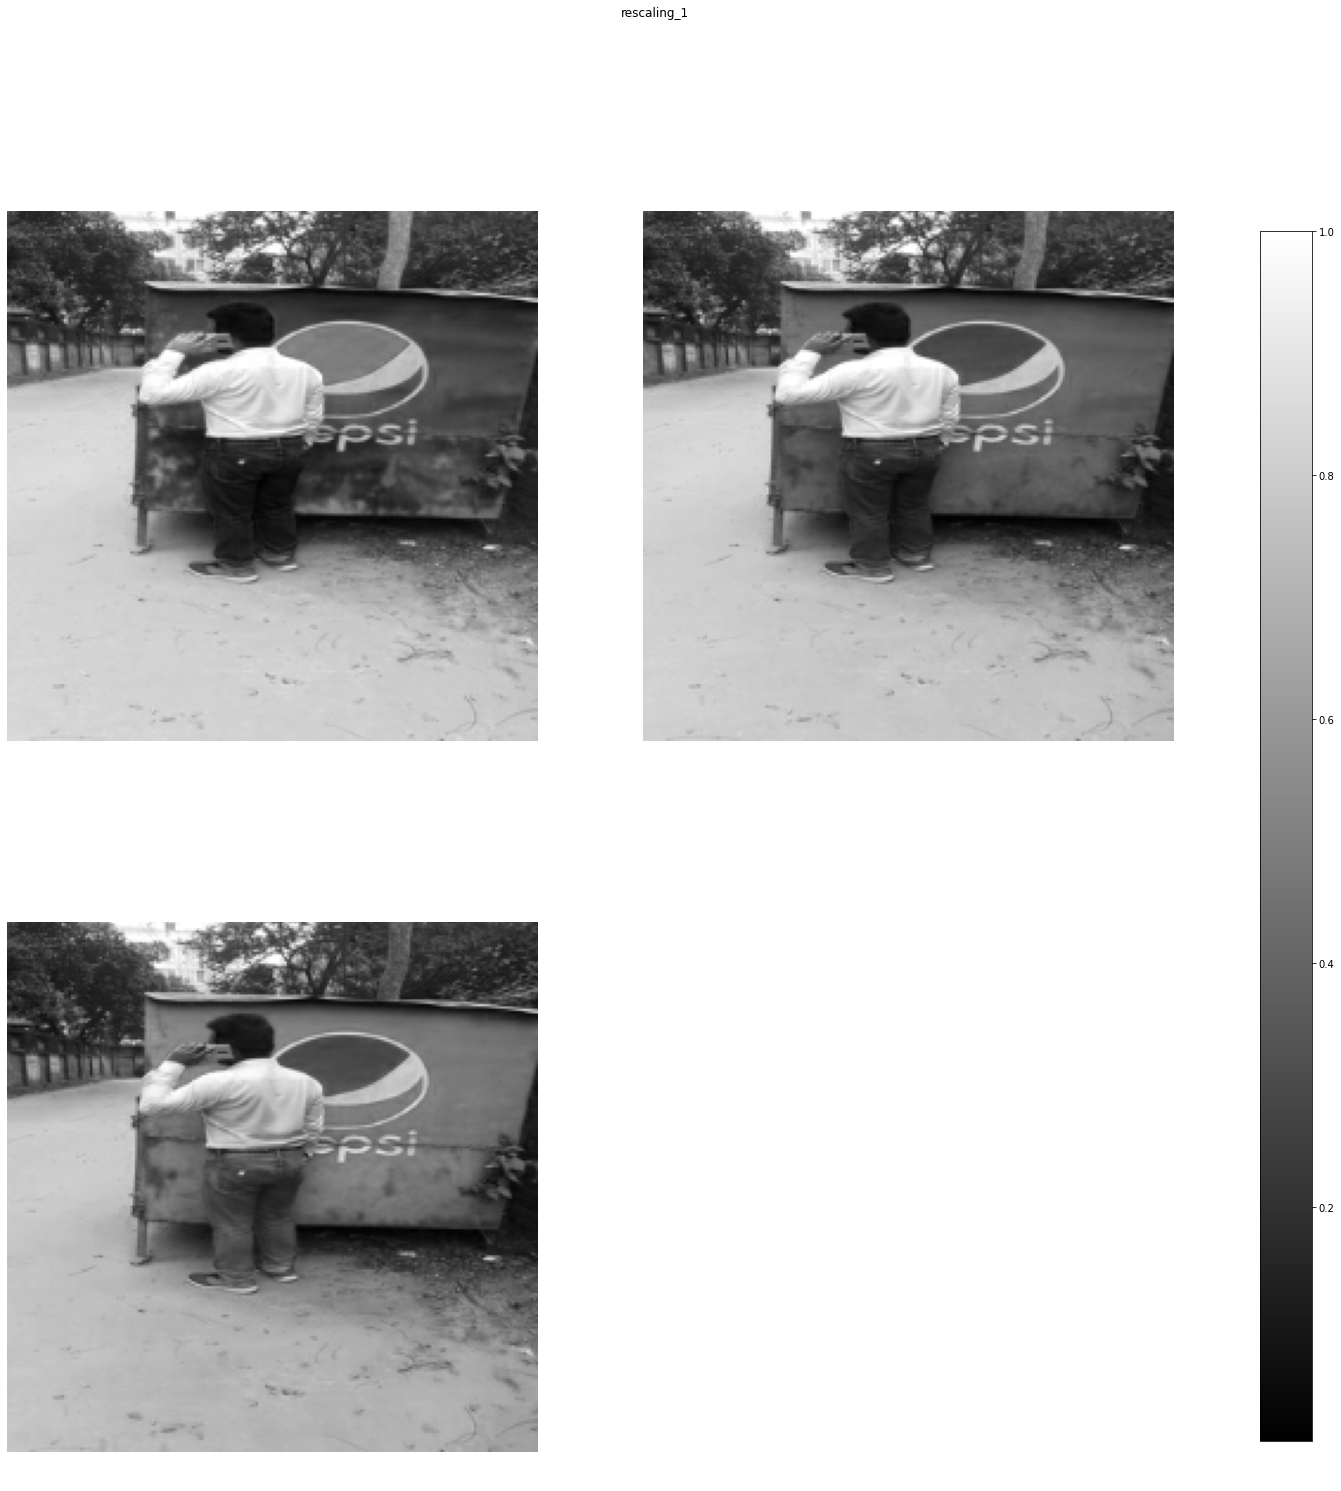

conv2d (1, 224, 224, 16) 


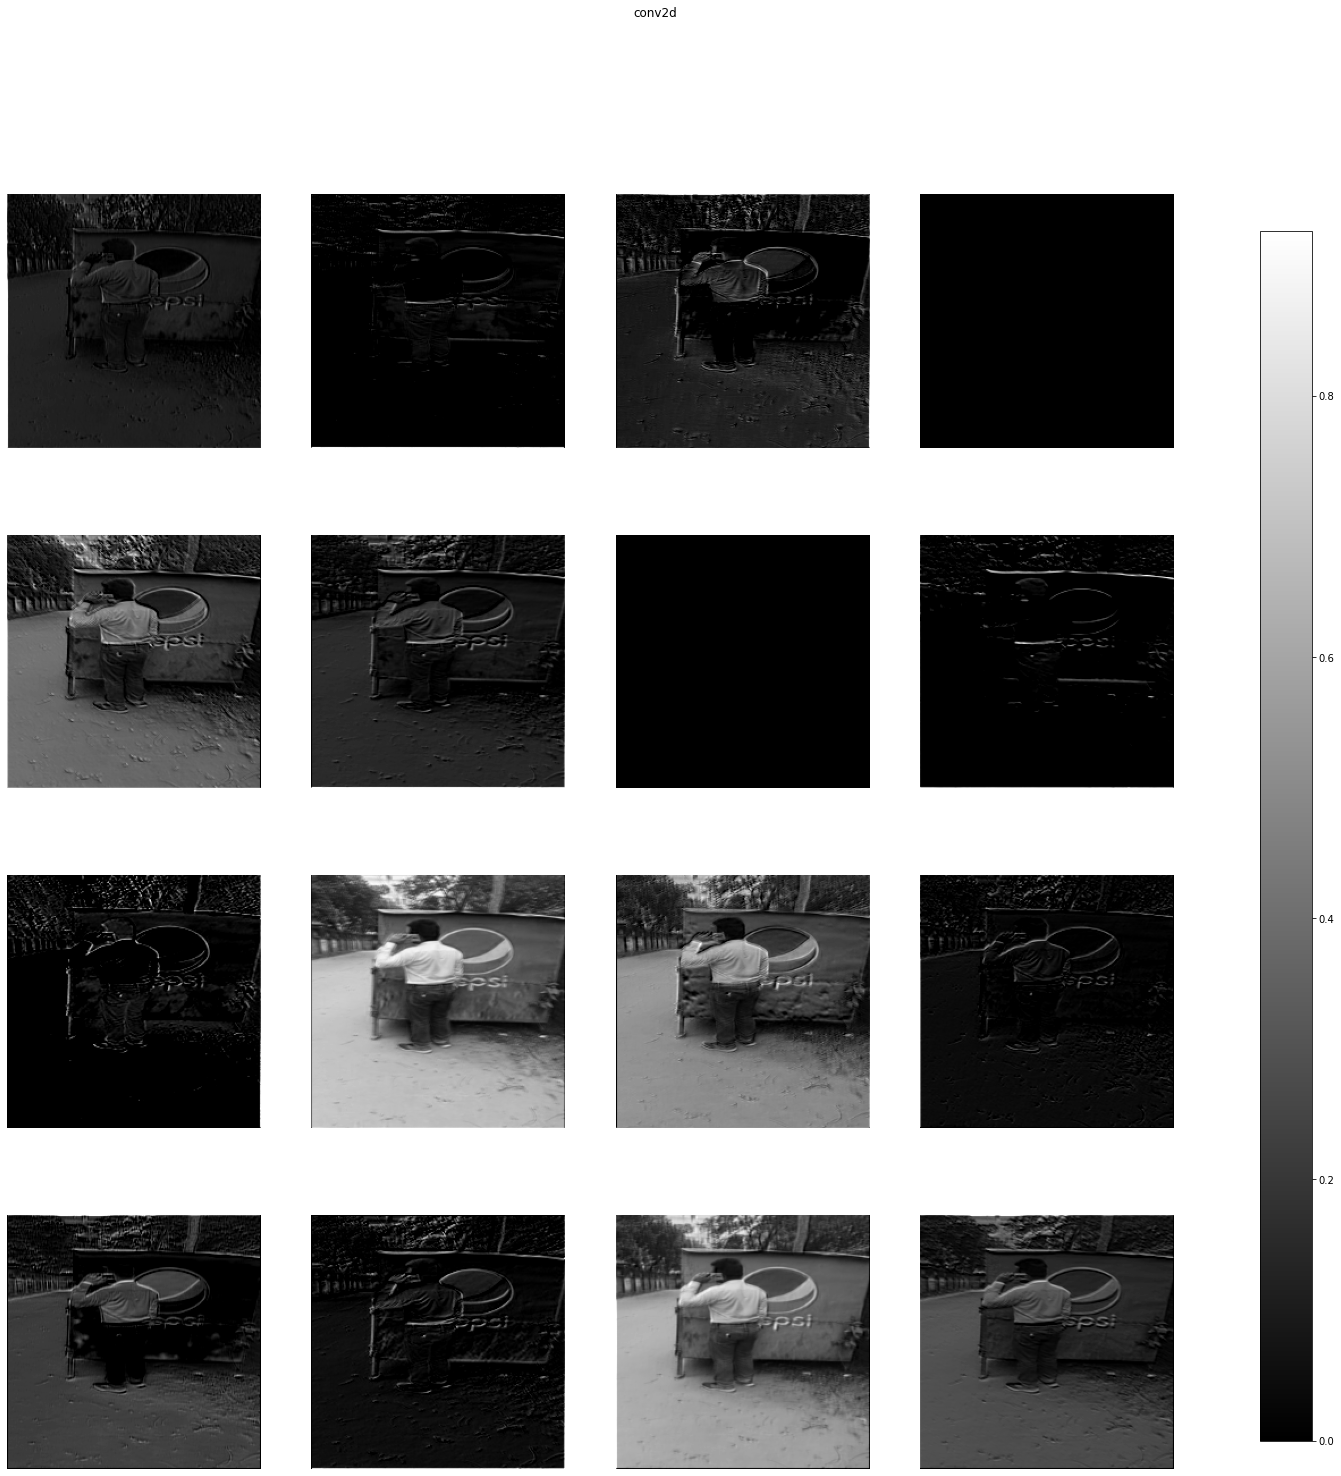

max_pooling2d (1, 112, 112, 16) 


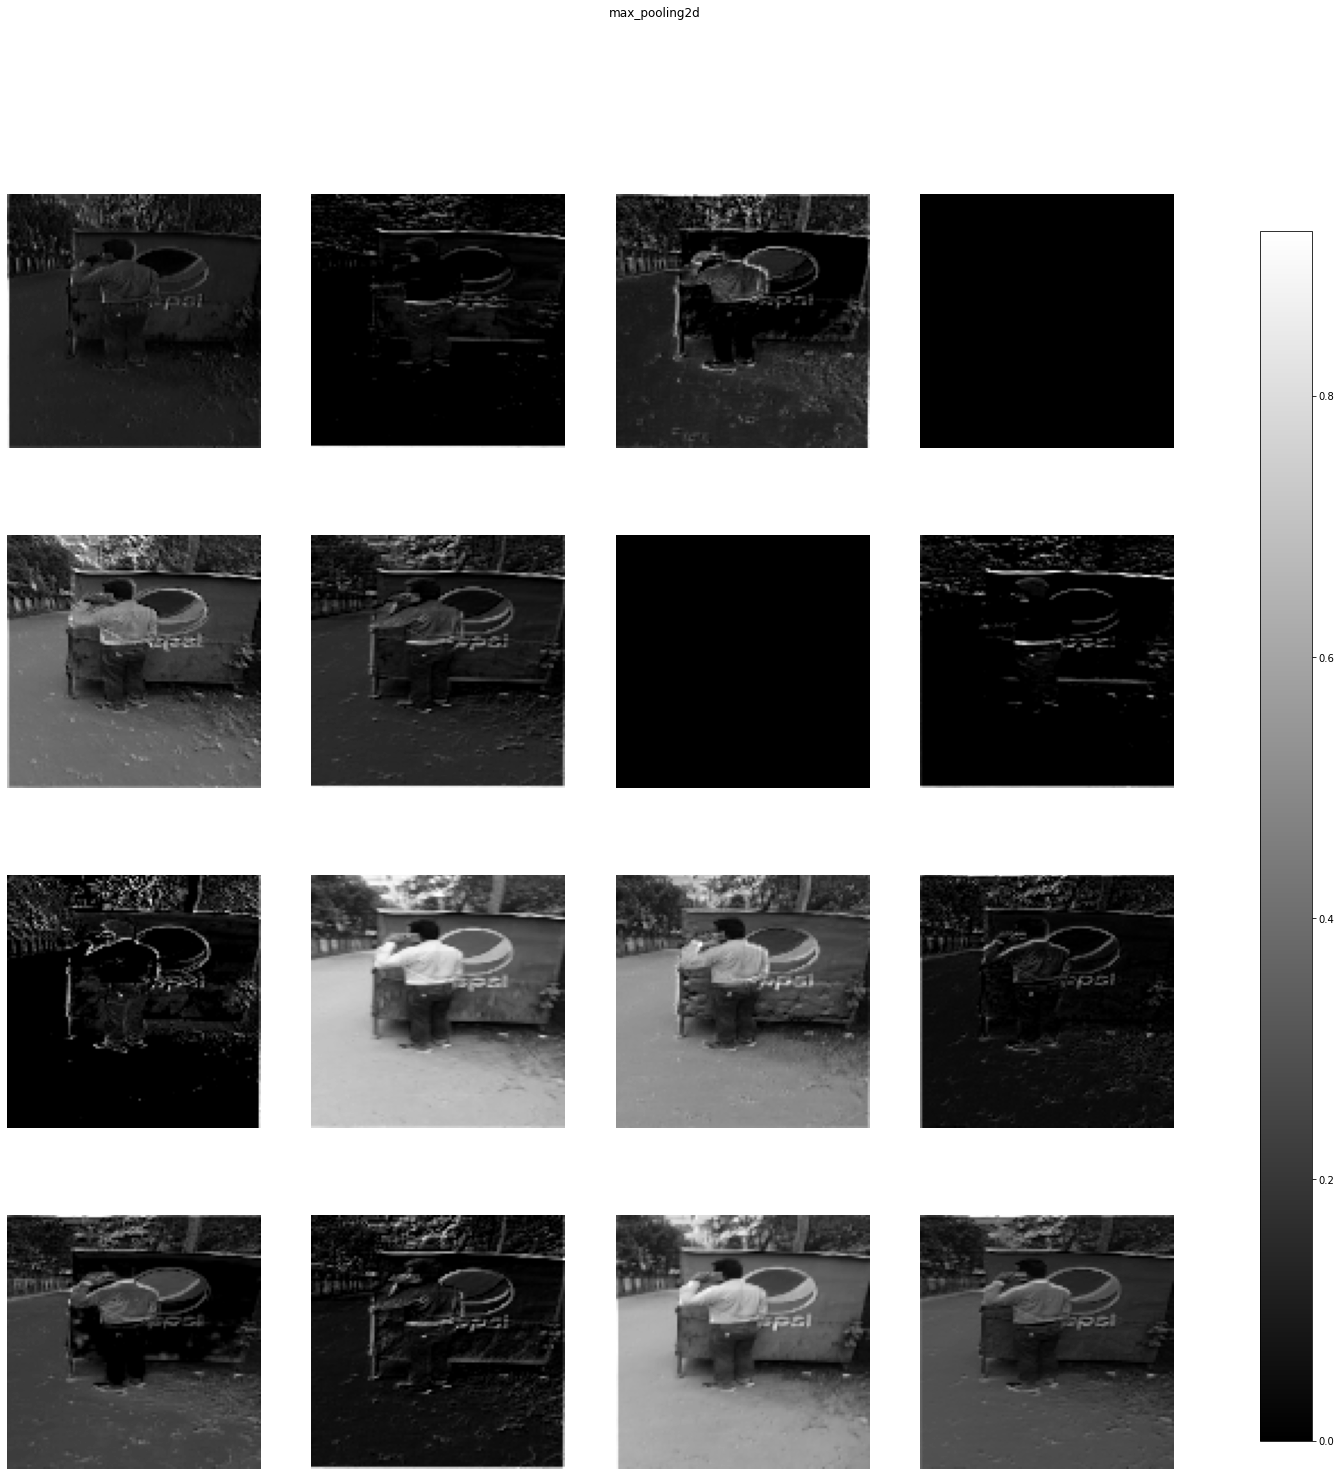

conv2d_1 (1, 112, 112, 32) 


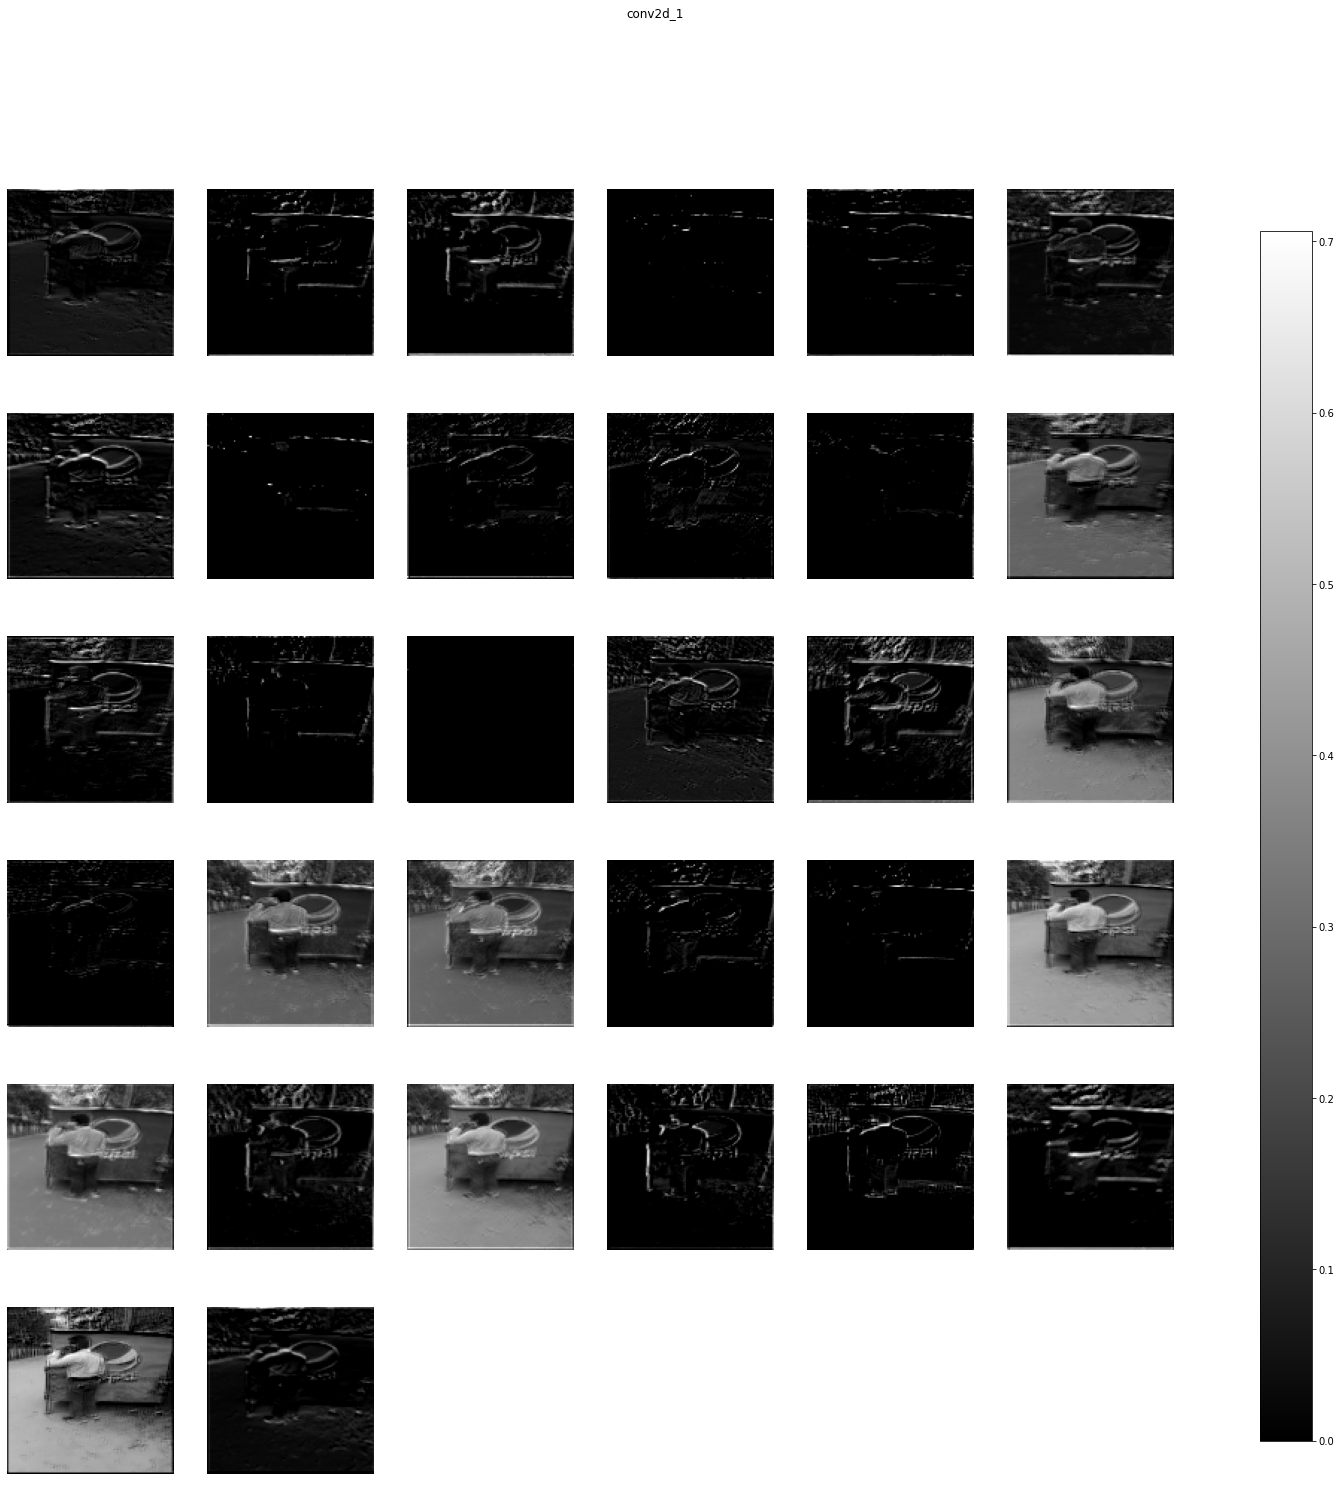

max_pooling2d_1 (1, 56, 56, 32) 


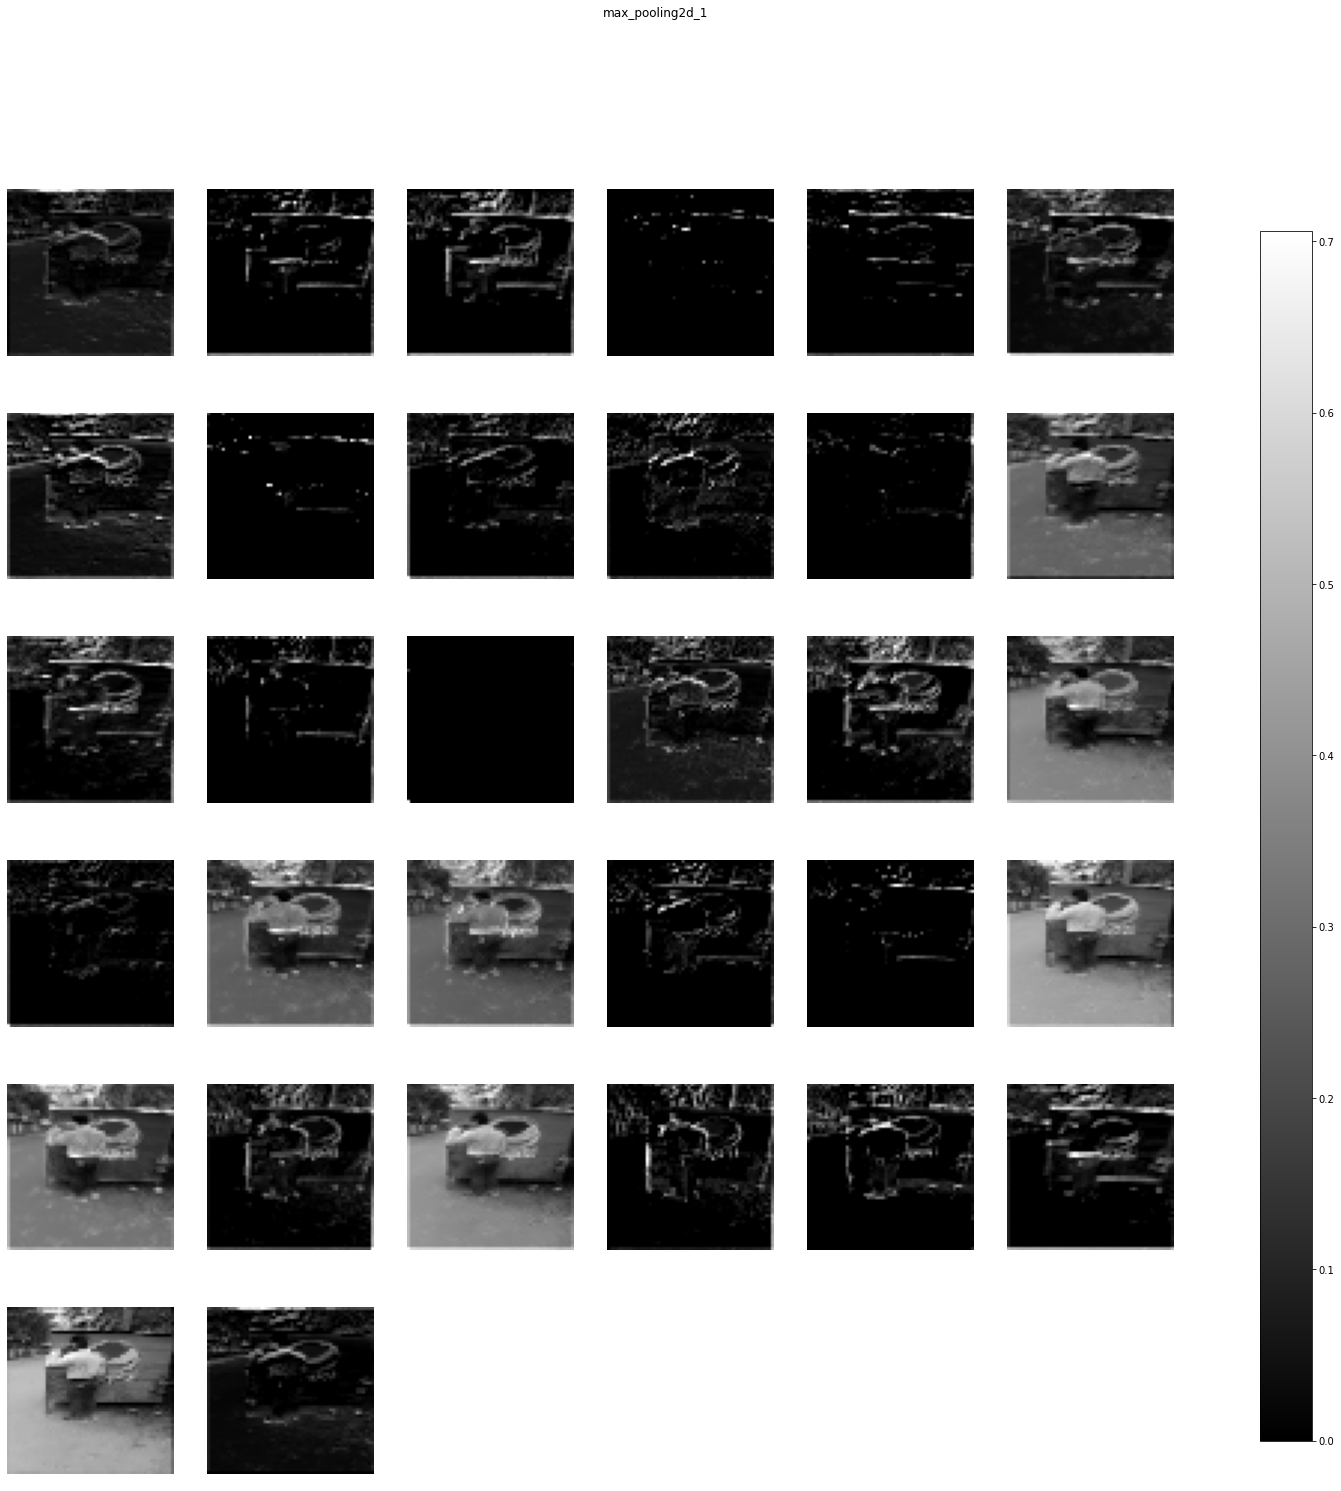

conv2d_2 (1, 56, 56, 64) 


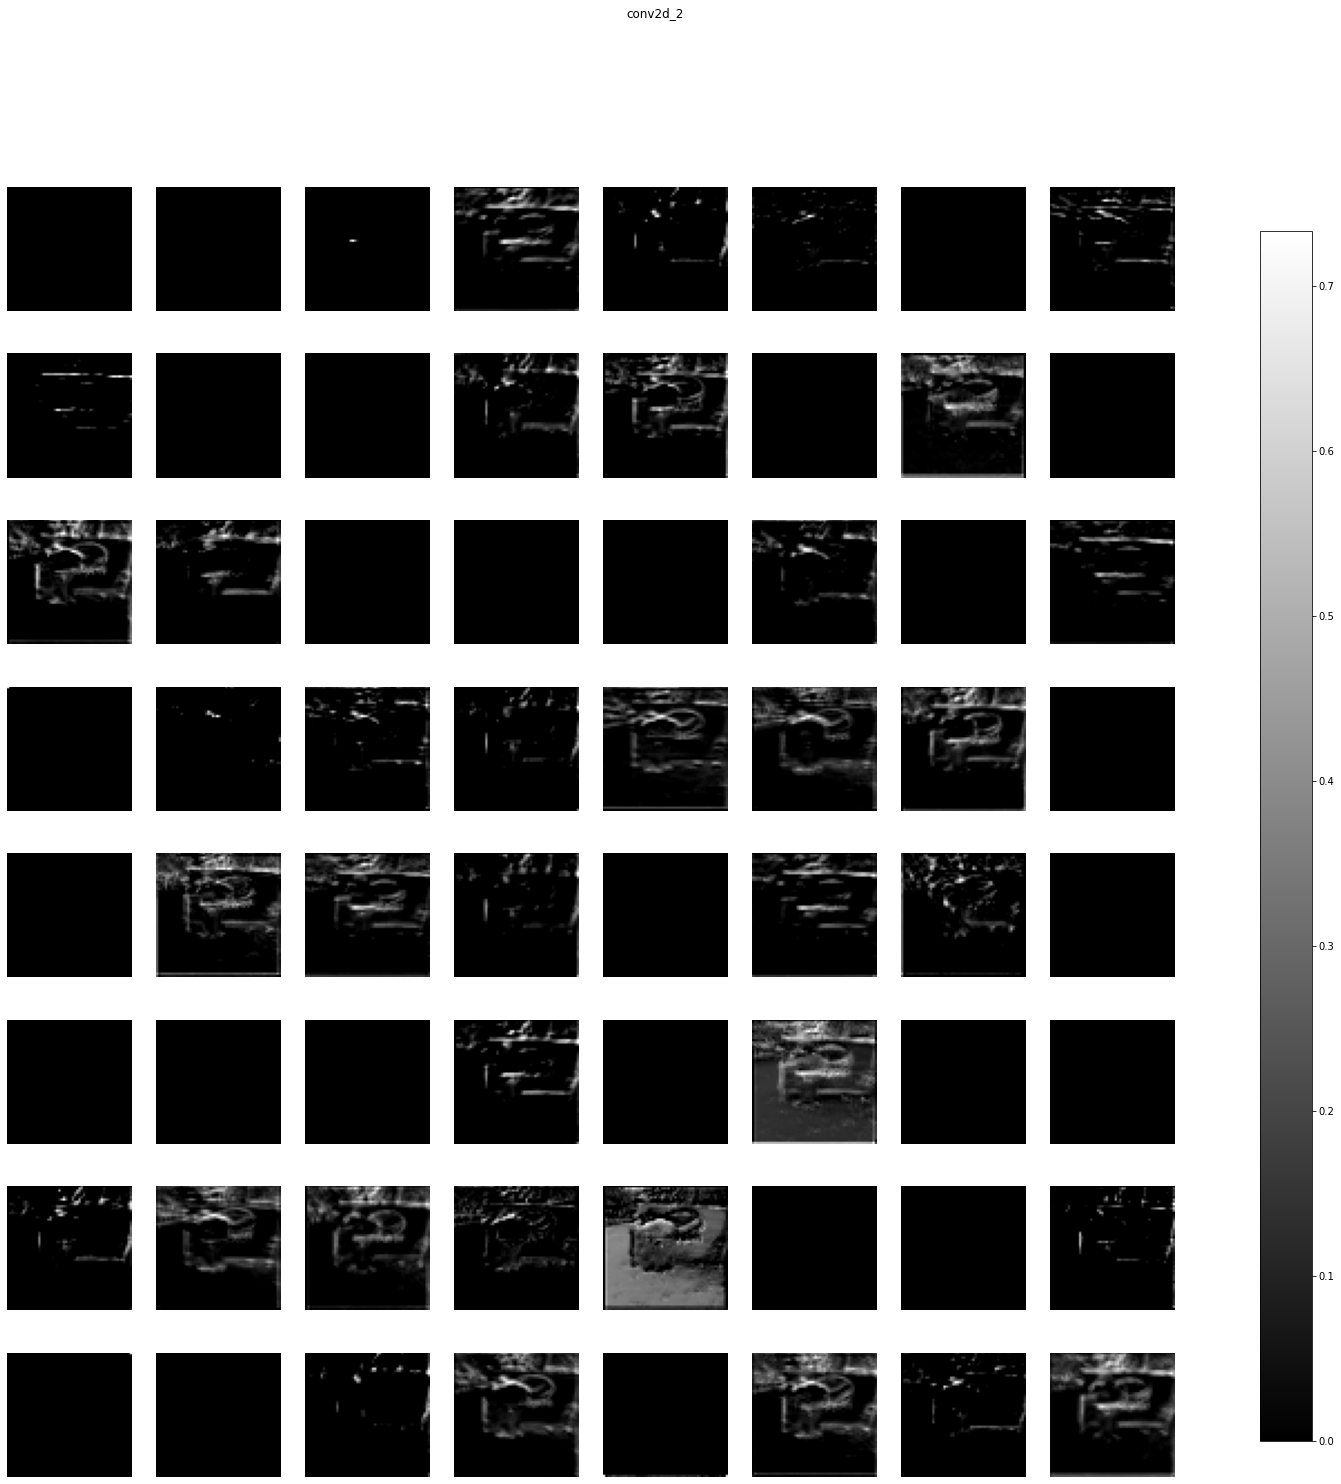

max_pooling2d_2 (1, 28, 28, 64) 


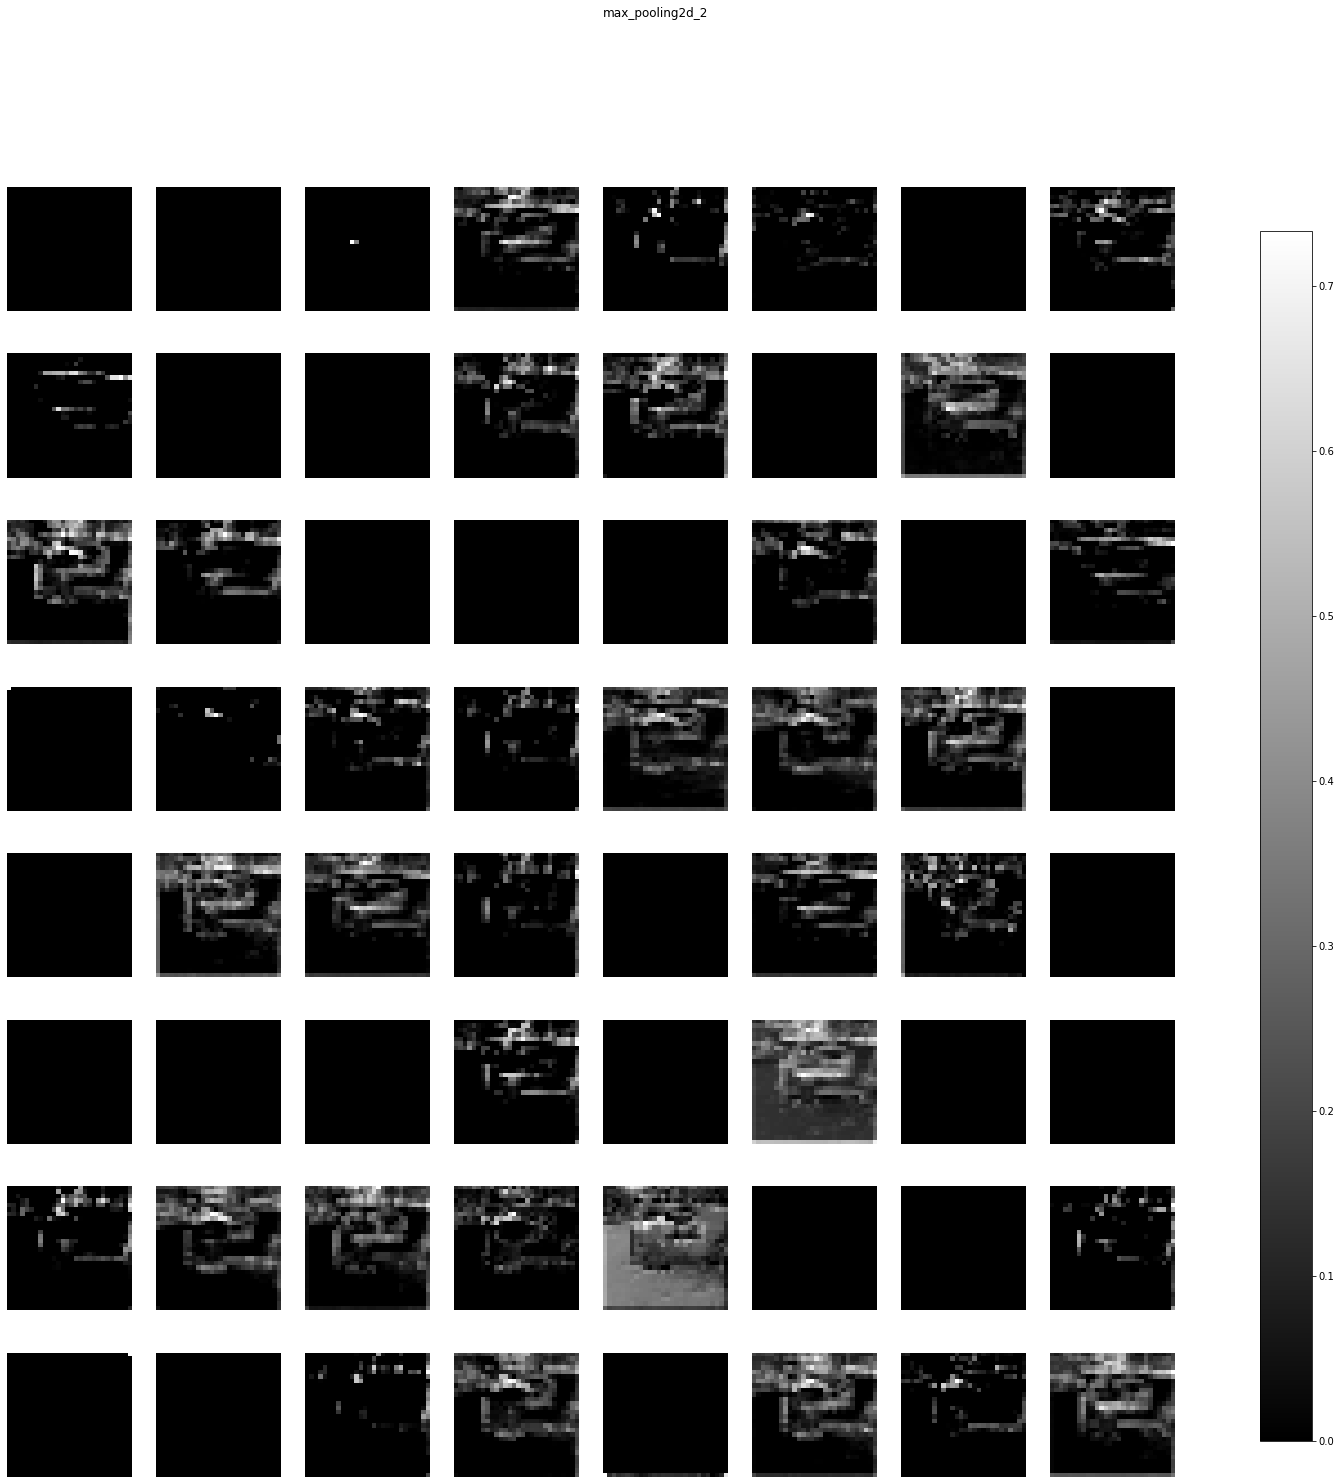

dropout (1, 28, 28, 64) 


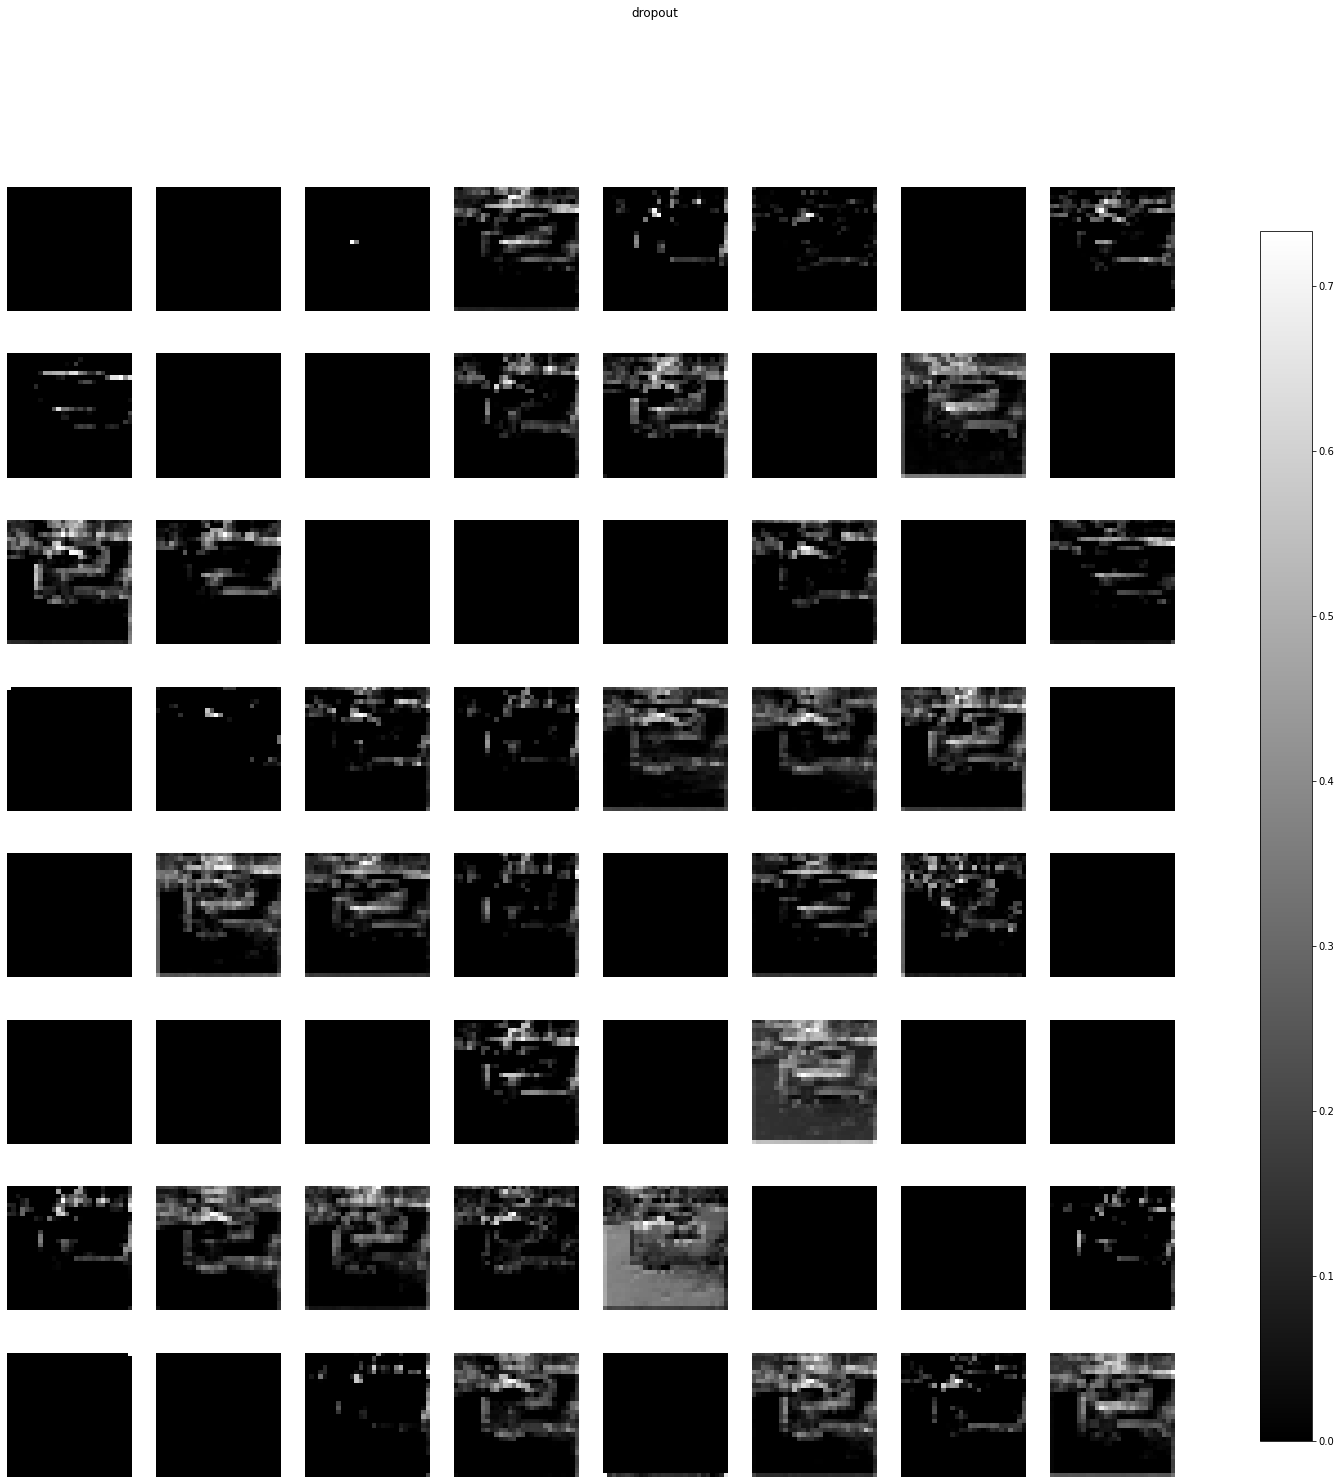

flatten (1, 50176) 


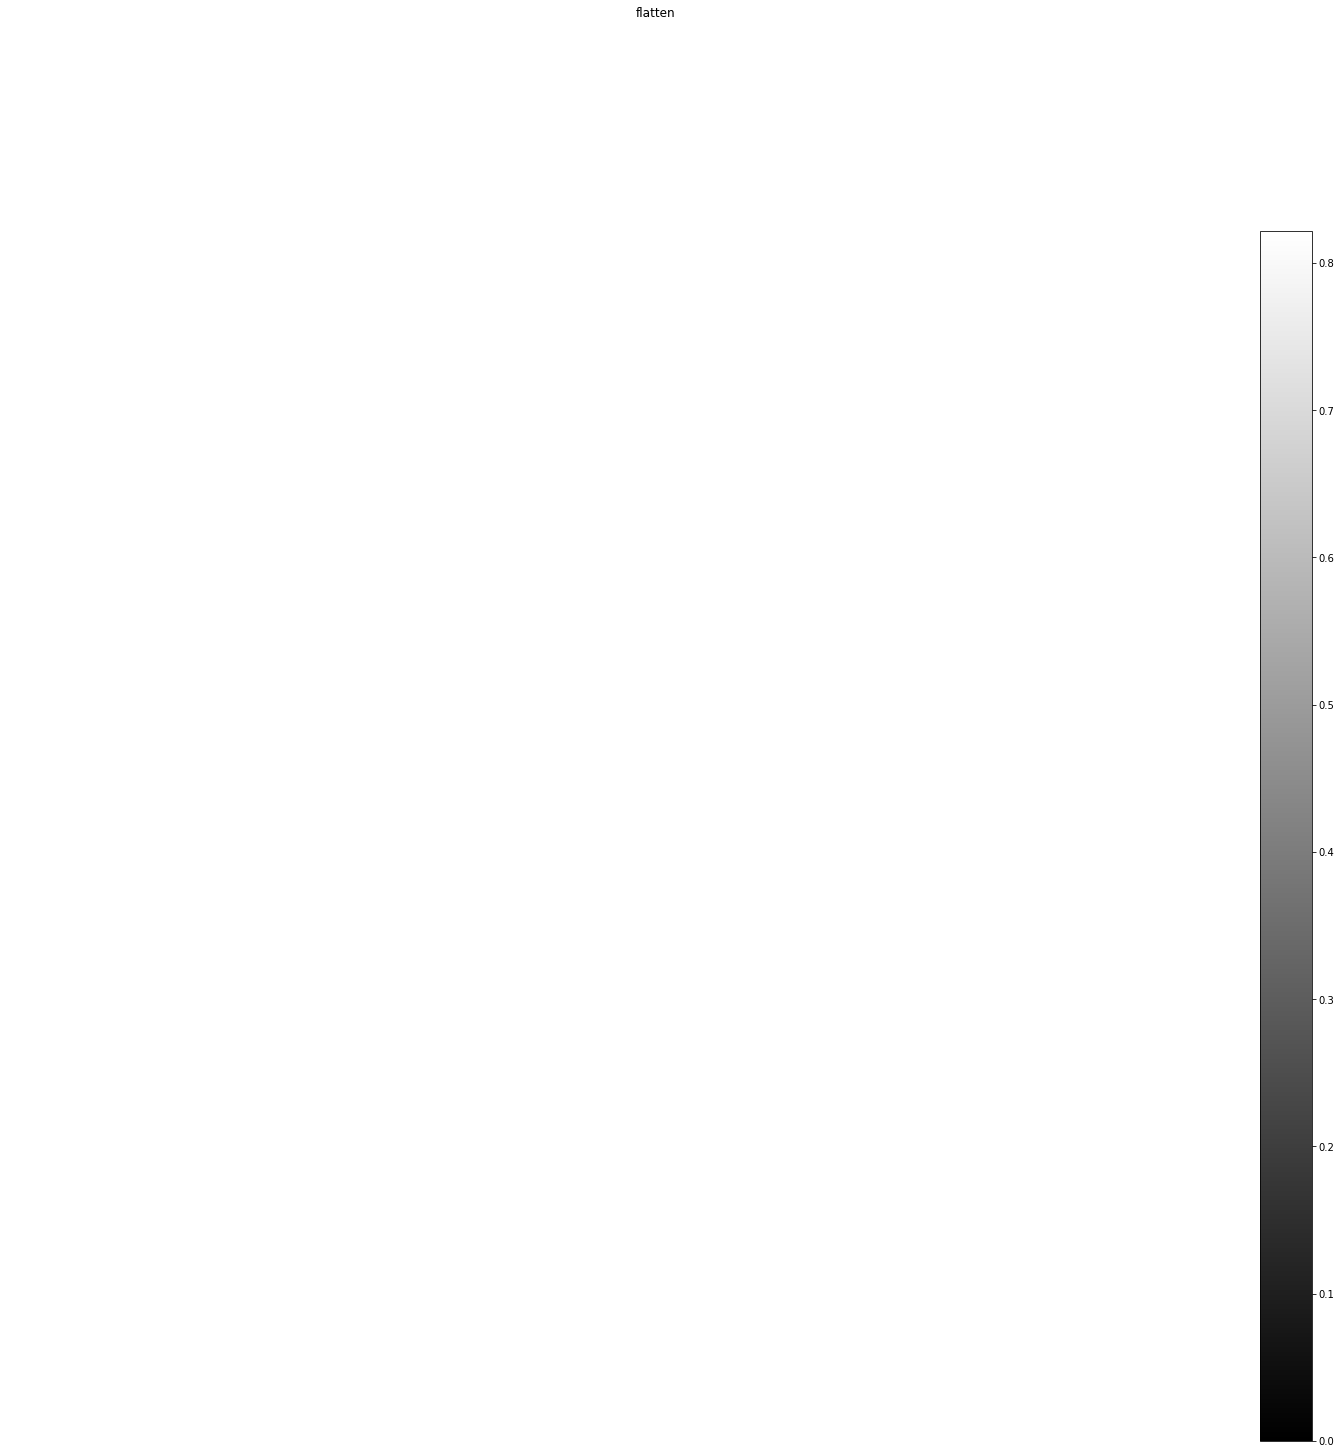

dense (1, 128) 


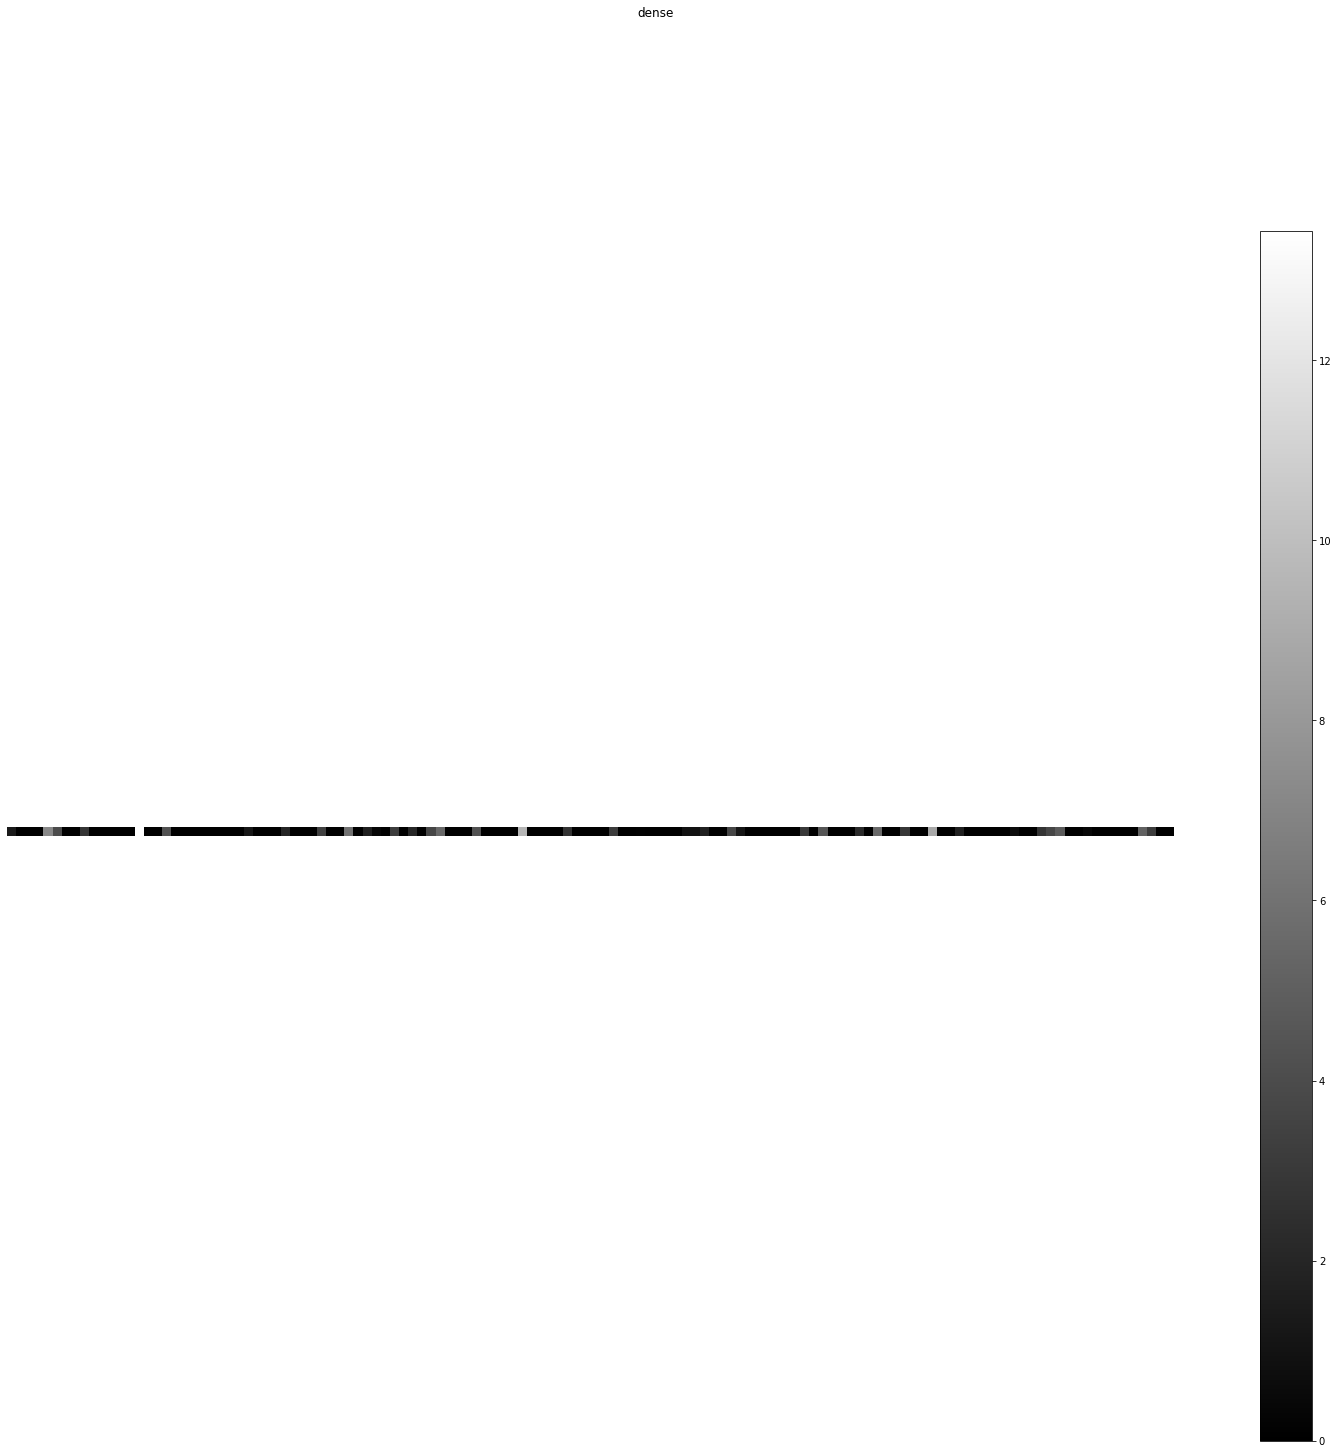

dense_1 (1, 7) 


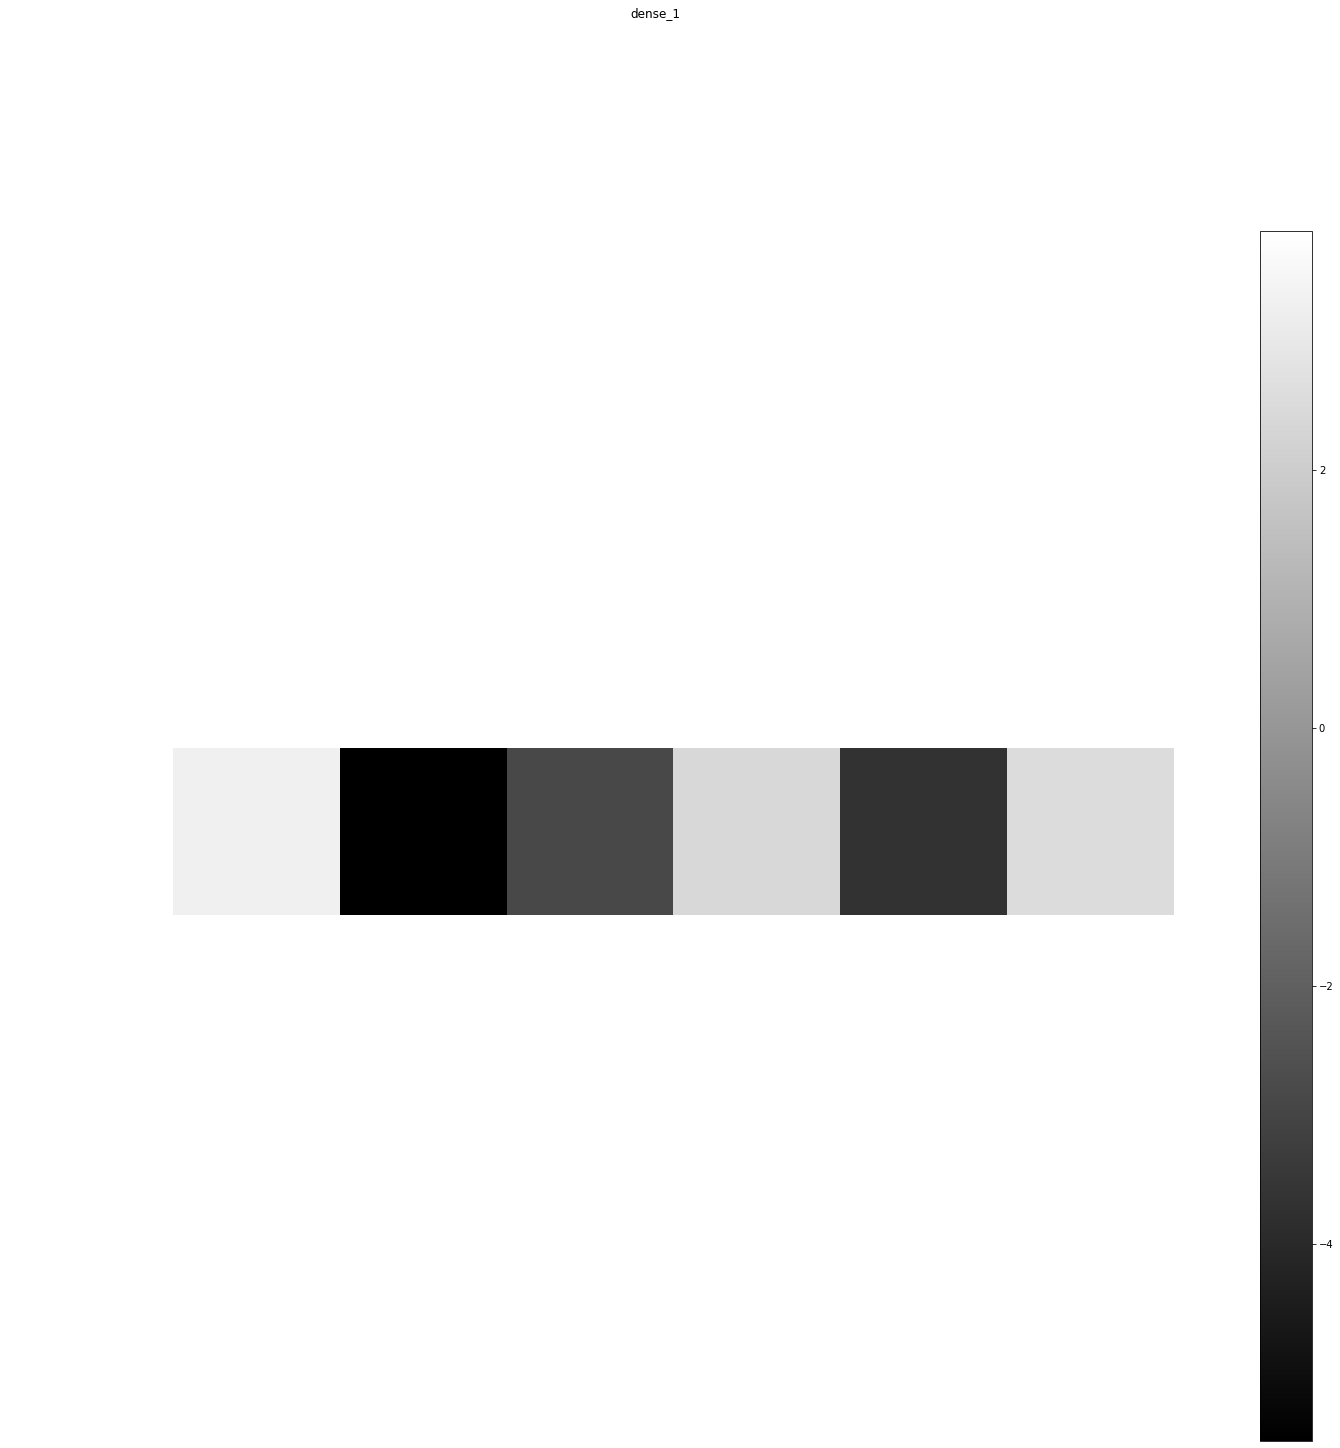

<Figure size 432x288 with 0 Axes>

In [ ]:
from keract import get_activations, display_activations

for image_batch, labels_batch in val_ds:
    keract_inputs=image_batch[:1]
    keract_targets=labels_batch[:1]
    break
activations = get_activations(model, keract_inputs)
display_activations(activations, cmap="gray", save=False)
plt.savefig('1.png')

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools 

In [26]:
for image_batch, labels_batch in val_ds:
  y_real=labels_batch
  break

In [27]:
y_real

<tf.Tensor: shape=(395,), dtype=int32, numpy=
array([1, 5, 3, 6, 4, 4, 1, 1, 6, 0, 2, 6, 3, 0, 1, 5, 5, 1, 1, 0, 6, 4,
       1, 0, 4, 6, 4, 0, 2, 4, 6, 4, 2, 2, 1, 0, 5, 3, 6, 5, 4, 0, 3, 2,
       5, 4, 2, 4, 1, 1, 1, 3, 5, 1, 6, 4, 3, 1, 5, 1, 5, 1, 2, 6, 4, 1,
       4, 2, 5, 3, 6, 3, 0, 3, 1, 6, 5, 0, 1, 0, 4, 5, 1, 6, 5, 0, 2, 5,
       1, 3, 1, 2, 6, 0, 4, 1, 4, 5, 3, 4, 0, 2, 6, 0, 1, 0, 5, 1, 1, 5,
       1, 3, 4, 0, 3, 3, 3, 5, 5, 3, 4, 6, 2, 4, 2, 2, 5, 3, 2, 5, 5, 5,
       3, 4, 4, 1, 6, 4, 5, 5, 1, 2, 6, 2, 1, 6, 0, 1, 6, 0, 2, 4, 1, 4,
       0, 1, 1, 2, 1, 5, 3, 6, 5, 5, 3, 1, 6, 0, 4, 5, 0, 2, 1, 1, 6, 3,
       4, 3, 4, 4, 1, 4, 1, 6, 6, 3, 5, 6, 2, 2, 3, 4, 0, 3, 5, 3, 4, 1,
       6, 2, 2, 0, 2, 5, 1, 6, 6, 5, 5, 4, 1, 6, 1, 2, 3, 1, 6, 1, 4, 3,
       6, 2, 5, 1, 6, 0, 6, 4, 5, 3, 0, 5, 4, 1, 0, 1, 1, 0, 0, 4, 3, 4,
       4, 1, 5, 4, 1, 4, 4, 3, 5, 1, 0, 6, 5, 6, 4, 4, 3, 1, 0, 1, 0, 3,
       0, 1, 0, 5, 4, 0, 3, 3, 6, 0, 4, 2, 5, 3, 1, 3, 4, 5, 0, 2, 3, 0,
     

In [28]:
Y_pred = model.predict_generator(val_ds, test_sample // batch_size+1)

y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [29]:
print('Confusion Matrix')

print(confusion_matrix(y_real, y_pred))

Confusion Matrix
[[15 11  1  0 14  1  9]
 [24 10  0  3 25  2 13]
 [ 5  0 12  4  1 14  0]
 [ 1  2  1 36 10  1  0]
 [ 8 10  1  2 35  0  8]
 [ 1  0  4  0  0 58  1]
 [12  9  0  0 18  1 12]]
